## Laid Line extraction from reflected light images
### 0. Load relevant packages

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
from matplotlib import cm
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

### 1. Pre-processing
Pixel size measurements can be done using Canny edge detection. As this part is dependent on details from the reflected light image, it isn't included in this code.

### 2. Patch selection
Again dependent on the image and needs to be done by the user independently.

### 3. Spectral TV decomposition
Code is available by e.g. Gilboa et al. (https://guygilboa.net.technion.ac.il/2020/10/09/spectral-total-variation-color/) in Matlab. Run the matlab code first and load the results here next. In case of obtaining the TV flow solution instead of the spectral TV decomposition directly, we have included code to derive the decomposition based on the TV flow solution. This may be more flexible when deciding how to filter the decomposition.

#### 3.1 Load Data

In [2]:
u = sio.loadmat('INSERT_FILE_NAME.mat')
u = u['u'] # This is assuming TV flow data, for spectral TV decomposition data based on the Gilboa et al. code write: u_0 = u_0['f_H'] to load filtered images.
u = np.moveaxis(u, -1, 0)

#### 3.2 a) Derive spectral TV decomposition from TV Flow data
This is in case TV flow results are loaded instead of the spectral decomposition results. Uncomment the following cell if spectral TV decomposed data was loaded directly.

In [3]:
# def spectral_TV_decomp(u,num_bands):
#     u0 = u[0,:,:]
#     u1 = u[1,:,:]
#     u2 = u[2,:,:]
#     Phi = []
#     dt = 2/75 # based on the discretisation in the TV flow solution
#     for i in range(num_bands): 
#         ddu = (u0+u2-2*u1)/(dt**2)
#         t = (i+1)*dt
#         phi = ddu*t
#         Phi.append(phi)
#         u0 = u1
#         u1 = u2
#         u2 = u[i+3,:,:]
#     f_r = (num_bands+1)*u1 - num_bands*u2 
#     return Phi, f_r

# num_bands=39 # in relation to the TV flow discretisation dt.
# Phi, f_r = spectral_TV_decomp(u,num_bands)
# phi = np.array(Phi)
# dec_phi = np.sum(phi[0:],axis=0)

#### 3.2 b) For directly loaded spectral TV decomposition data
Comment the following cell if spectral TV decomposition data was loaded directly and not TV flow data.

In [4]:
dec_phi = u

### 4. Radon transform
Detect laid lines in the Radon domain. 

In [5]:
theta = np.linspace(0., 180., max(dec_phi.shape), endpoint=False)
sinogram = radon(dec_phi, theta=theta) 
dx, dy = 0.5 * 180. / max(dec_phi.shape), 0.5 / sinogram.shape[0] 

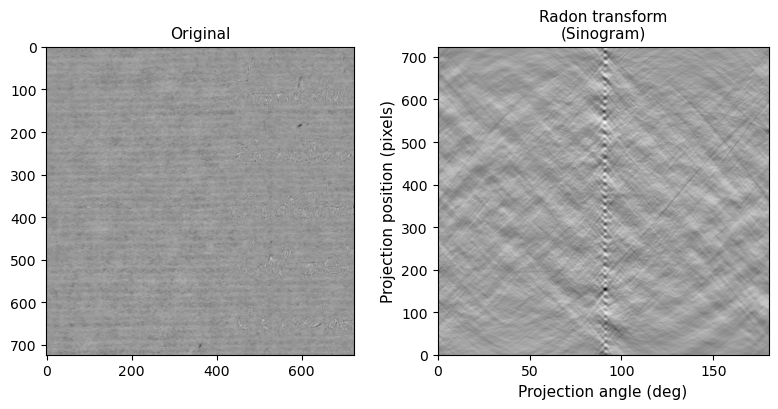

In [6]:
# Display Radon Trafo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4.2))

ax1.set_title("Original", fontsize=11)
ax1.imshow(dec_phi, cmap='gray') 

ax2.set_title("Radon transform\n(Sinogram)", fontsize=11)
ax2.set_xlabel("Projection angle (deg)", fontsize=11)
ax2.set_ylabel("Projection position (pixels)", fontsize=11)
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy), 
           aspect='auto')

fig.tight_layout()
plt.show()

### 5. Cross-section
Take a cross-section along the relevant angle to obtain line peaks. We determine the relevant angle by finding the angle of highest magnitude:

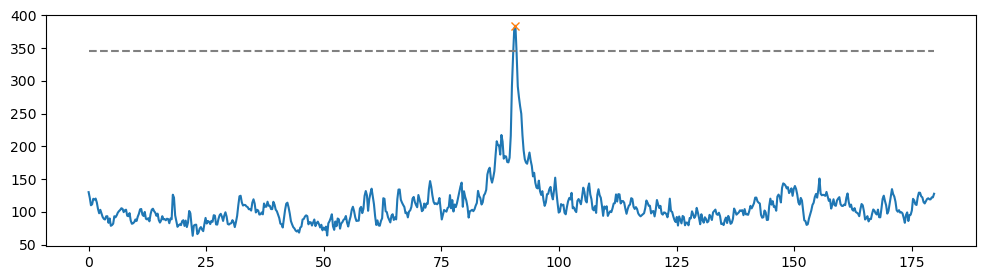

In [7]:
x = []
y = []
for i in range(theta.shape[0]):
    y.append(np.max(sinogram[:,i]))
    x.append(theta[i])
y = np.array(y)
x = np.array(x)

height=345
peaks_y, _ = find_peaks(y, height=height)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(x,y)
ax.plot(x[peaks_y], y[peaks_y], "x")
ax.plot(x,height*np.ones_like(x), "--", color="gray")
plt.show()

# --> Decide on theta to be used
thet = x[peaks_y[0]]
thet_idx = peaks_y[0]

### 6. Peak detection
Locate peaks with highest magnitude, representing the laid lines based on the angle determined above. The parameter "height" determines the threshold for peak detection and is to be chosen manually. We include gaussian smoothing of the 1D signal to filter out noise.

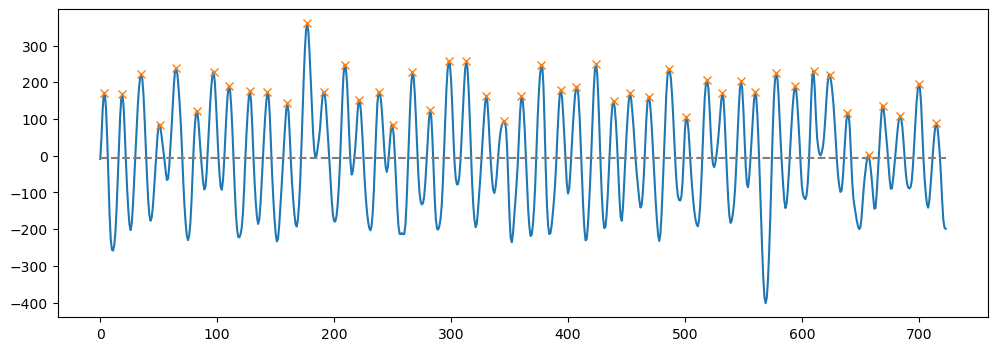

In [8]:
height = -5
std = 1 # standard deviation of the gaussian kernel for filtering
fil=1
if fil ==1:
    sino = gaussian_filter1d(sinogram[:,thet_idx],std) # smoothing of the signal
else:
    sino = sinogram[:,thet_idx]
    
peaks, _ = find_peaks(sino, height=height)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(sino)
ax.plot(peaks, sino[peaks], "x")
ax.plot(height*np.ones_like(sinogram[:,thet_idx]), "--", color="gray")
plt.show()

### 7. Laid Line density measurement and plotting

In [9]:
px_cm = 155# Number of pixels per centimetre
num_avg = len(peaks)/(np.max(dec_phi.shape)/px_cm)
print('The average number of laid lines per centimetre are ', num_avg)

The average number of laid lines per centimetre are  10.062154696132596


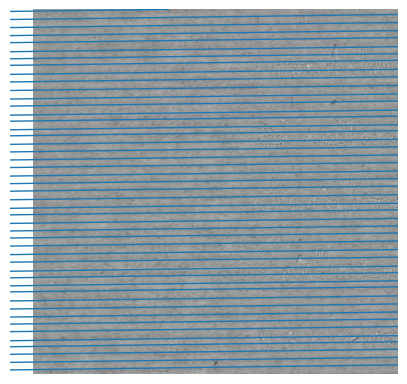

In [10]:
plt.figure(figsize=(5,5), constrained_layout=False)
plt.imshow(dec_phi, cmap=cm.gray)
plt.axis('off')

for peak in peaks:
    (x0, y0) = peak * np.array([np.cos(np.deg2rad(thet)), np.sin(np.deg2rad(thet))])
    plt.axline((x0, y0), slope=-np.tan(np.deg2rad(thet)+ np.pi/2),linewidth=1)